In [2]:
import numpy as np
import os
import glob
import logging
import json
import sys
sys.path.append("/workspace/zecheng/modelzipper/projects")
from tqdm import tqdm
from concurrent import futures
from argparse import ArgumentParser
from change_deepsvg.svglib.svg import SVG
from change_deepsvg.svglib.geom import Bbox, Angle, Point
from change_deepsvg.difflib.tensor import SVGTensor
from modelzipper.tutils import *
import torch
from tqdm import trange
from PIL import Image


FILE = "/zecheng2/svg/icon-shop/meta_data/test_generation_results/checkpoint-2920_offline_750_valid_v2_sampled_1000_all.jsonl"
# SAVE_DIR = "/zecheng2/vqllama/baselines/test_baselines/layoutnuwa"

data = auto_read_data(FILE)

print(data[0].keys())


ModelZipper is ready for launch🚀 | Current Version🦄 >>> 0.2.6 <<< | AOE Time🕒 2024-01-23 23:22:47
begin to read data from /zecheng2/svg/icon-shop/meta_data/test_generation_results/checkpoint-2920_offline_750_valid_v2_sampled_1000_all.jsonl ...
dict_keys(['golden_svg', 'processed_res', 'prompt', 'file_path'])


1. Keywords: sunny, Cloud, weather #Begin:
2. bulb
3. Truck, Lorry, Vehicle, wagon
4. clock
5. Electric chip

1000
Keywords: sunny, Cloud, weather #Begin:


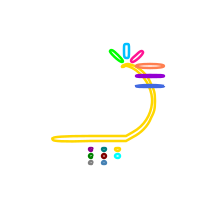

Keywords: bulb #Begin:


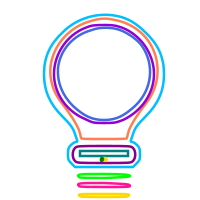

Keywords: Truck, Lorry, Vehicle, wagon #Begin:


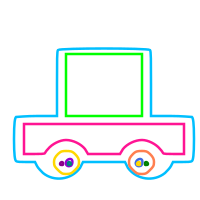

Keywords: four o'clock #Begin:


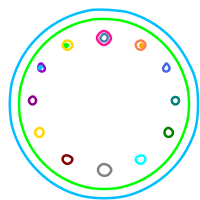

Keywords: new #Begin:


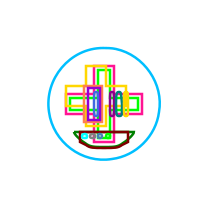

In [3]:
ID = [20, 79, 98, 132, 669]

all_processed_res = [x['processed_res'] for x in data]
all_prompts = [x['prompt'] for x in data]

print(len(all_prompts))

for i in range(len(ID)):
    gen_svg = SVG.from_str(all_processed_res[ID[i]][0])

    print(all_prompts[ID[i]])

    svg_tensor = gen_svg.to_tensor()[7:]
    svg = SVGTensor.from_data(svg_tensor)
    svg_ = SVG.from_tensor(svg.data, viewbox=Bbox(200))
    svg_.normalize().draw_colored(fill=True, file_path=f"/workspace/zecheng/modelzipper/projects/custom_llama/baselines/analysis/image{i}.png")

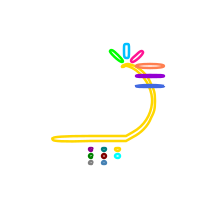

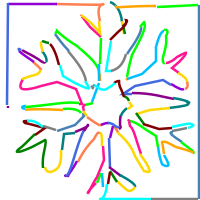

In [43]:
meta_data = []

for i in trange(len(data)):
    keywords = data[i]["prompt"].split('Keywords:')[-1].split('#Begin:')[0].strip()
    processed_svg_path = data[i]['processed_res']
    file_path = data[i]['file_path'].replace('zecheng', 'zecheng2')
    golden_svg = data[i]['golden_svg']
    
    svg = SVG.from_str(processed_svg_path[0])
    svg_tensor = svg.to_tensor()[7:]
    if len(svg_tensor) == 0:
        continue
    svg = SVGTensor.from_data(svg_tensor)
    svg_ = SVG.from_tensor(svg.data, viewbox=Bbox(200))
    svg_ = svg_.normalize().split_paths().set_color("random")
    save_path = os.path.join(SAVE_DIR, f"images/{i}.png")
    svg_.save_png(save_path)
    
    cur_meta = {
        "keywords": keywords,
        "file_path": file_path,
        "golden_svg": golden_svg,
        "processed_png": save_path,
        "processed_svg_path": processed_svg_path,
    }
    
    meta_data.append(cur_meta)
    

auto_save_data(meta_data, os.path.join(SAVE_DIR, "meta_data.jsonl"))
    
    

100%|██████████| 1000/1000 [00:55<00:00, 17.95it/s]


jsonl file saved successfully!
Save file to /zecheng2/vqllama/baselines/test_baselines/layoutnuwa/meta_data.jsonl | len: 939


In [46]:
def merge_images(
        image_path_lst, raw_image_size_w=None, raw_image_size_h=None, image_row=10, image_col=10,
    ):
    image_list = []
    for image_path in image_path_lst:
        image = Image.open(image_path)
        image_list.append(image)

    sub_image_w = raw_image_size_w if raw_image_size_w is not None else image_list[0].size[0]
    sub_image_h = raw_image_size_h if raw_image_size_h is not None else image_list[0].size[1]

    big_image_size = (sub_image_w * image_row, sub_image_h * image_col)
    big_image = Image.new('RGB', big_image_size)
    big_images = []

    for i, image in enumerate(image_list):
        i = i % (image_row * image_col)
        row = i // image_row
        col = i % image_col
        big_image.paste(image, (col * image.size[0], row * image.size[1]))
        
        if (i + 1) % (image_row * image_col) == 0:
            big_images.append(big_image)
            big_image = Image.new('RGB', big_image_size)

    return big_images


image_paths = [x["processed_png"] for x in meta_data]

big_images = merge_images(image_paths)

BIG_IMAGE_DIR = os.path.join(SAVE_DIR, "big_images")
auto_mkdir(BIG_IMAGE_DIR)

for i, big_image in enumerate(big_images):
    big_image.save(os.path.join(BIG_IMAGE_DIR, f"{i}.png"))

/zecheng2/vqllama/baselines/test_baselines/layoutnuwa/big_images not exist! --> Create dir /zecheng2/vqllama/baselines/test_baselines/layoutnuwa/big_images


In [48]:
keywords = [x["keywords"] for x in meta_data]
len(keywords)

939

In [50]:
keywords[29]

'Lightning, sun, sky, Sun Lightning, weather, outdoors'